In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [2]:
date_parser = lambda x: dt.datetime.strptime(x[0:16], '%d.%m.%Y %H:%M')

In [3]:
data_raw1 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast - Actual_201501010000-201601010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw2 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast- Actual_201601010000-201701010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw3 = pd.read_csv('./raw_data/Total Load - Day Ahead Forecast - Actual_201701010000-201801010000.csv',
                        index_col=0, date_parser=date_parser)


data_raw1_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201501010000-201601010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw2_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201601010000-201701010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw3_f = pd.read_csv('./raw_data/Generation Forecasts - Day Ahead for Wind and Solar_201701010000-201801010000.csv',
                        index_col=0, date_parser=date_parser)

data_raw= pd.concat([data_raw1, data_raw2, data_raw3, data_raw1_f, data_raw2_f, data_raw3_f])

In [4]:
data_raw = data_raw.replace(['-', 'n/e'], np.NaN).dropna(how='all')

In [5]:
data_raw.columns

Index(['Actual Total Load [MW] - BZN|DE-AT-LU',
       'Day-ahead Total Load Forecast [MW] - BZN|DE-AT-LU',
       'Generation - Solar  [MW] (D) / BZN|DE-AT-LU',
       'Generation - Sum [MW] (D) / BZN|DE-AT-LU',
       'Generation - Wind Offshore  [MW] (D) / BZN|DE-AT-LU',
       'Generation - Wind Onshore  [MW] (D) / BZN|DE-AT-LU'],
      dtype='object')

In [6]:
# ['Day-ahead Total Load Forecast [MW] - BZN|DE-AT-LU']
data = pd.DataFrame(data_raw.astype(float))

data.columns = ['DA_load_forecast', 'DA_load_actual', 'solar_forecast', 'sum_forecast', 'offshore_forecast', 'onshore_forecast']

In [7]:
actual = pd.read_csv('./processed_data/20150101-20170830-gen_per_prod_type.csv', parse_dates=True, index_col=0)

In [19]:
data.onshore_forecast.describe()

count    94268.000000
mean      8622.471348
std       6725.535092
min        187.000000
25%       3638.000000
50%       6631.000000
75%      11475.000000
max      37338.000000
Name: onshore_forecast, dtype: float64

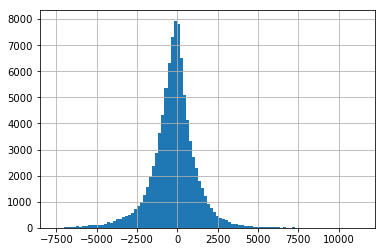

In [17]:
(actual.wind_onshore - data.onshore_forecast).dropna().hist(bins=100)

In [20]:
data.solar_forecast.describe()

count    94268.000000
mean      4394.367293
std       6531.778505
min          0.000000
25%          0.000000
50%        196.000000
75%       7282.000000
max      28310.000000
Name: solar_forecast, dtype: float64

(0, 6000)

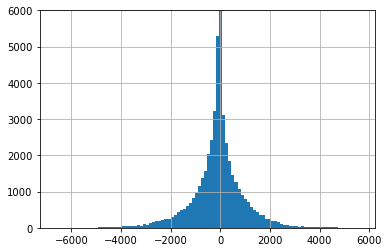

In [25]:
f, ax = plt.subplots()
(actual.solar - data.solar_forecast).dropna().hist(bins=100, ax=ax)
ax.set_ylim([0, 6000])

In [26]:
data.offshore_forecast.describe()

count    94172.000000
mean      1335.974971
std       1044.548125
min          4.000000
25%        429.000000
50%       1067.000000
75%       2160.000000
max       4175.000000
Name: offshore_forecast, dtype: float64

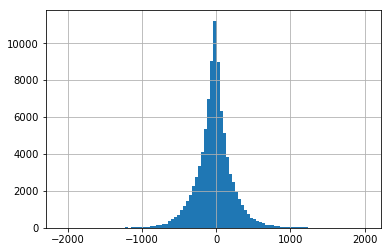

In [29]:
(actual.wind_offshore - data.offshore_forecast).dropna().hist(bins=100)

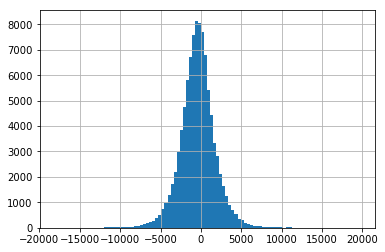

In [11]:
(data.DA_load_actual - data.DA_load_forecast).dropna().hist(bins=100)

In [12]:
actual = actual.resample('1H').mean()

In [13]:
data = data.resample('1H').mean()

In [14]:
actual['load'] = data.DA_load_actual

In [9]:
actual = actual[['solar', 'wind_offshore', 'wind_onshore', 'brown_coal', 'hard_coal', 'nuclear']]
# actual = actual[['solar', 'wind_offshore', 'wind_onshore']]

In [16]:
missing = actual.iloc[pd.isnull(actual).any(1).nonzero()[0]]

In [17]:
big_gaps = (actual.dropna().index.to_series().diff() > pd.Timedelta('24:00:00'))

In [18]:
big_gaps[big_gaps]

MTU
2015-01-14 14:00:00    True
2015-03-01 01:00:00    True
2015-04-27 09:00:00    True
2015-09-28 00:00:00    True
2016-06-01 23:00:00    True
2016-08-07 00:00:00    True
2016-10-29 00:00:00    True
2016-11-02 00:00:00    True
2017-08-12 00:00:00    True
Name: MTU, dtype: bool

In [19]:
for col in actual.columns:
    for row in actual.loc[actual[col].isnull(), col].index:
        actual.loc[row, col] = actual[col].shift(24).loc[row]

In [20]:
any(actual.dropna().index.to_series().diff() > pd.Timedelta('01:00:00'))

False

In [60]:
scaler = RobustScaler()

In [61]:
cols = actual.columns

In [62]:
cols

Index(['biomass', 'brown_coal', 'hard_coal', 'wind_offshore', 'pumped_hydro',
       'solar', 'river_hydro', 'wind_onshore', 'nuclear', 'other', 'load'],
      dtype='object')

In [63]:
data_scaled = pd.DataFrame(index = actual.index, columns=cols)

In [64]:
data_scaled[cols] = scaler.fit_transform(actual[cols])

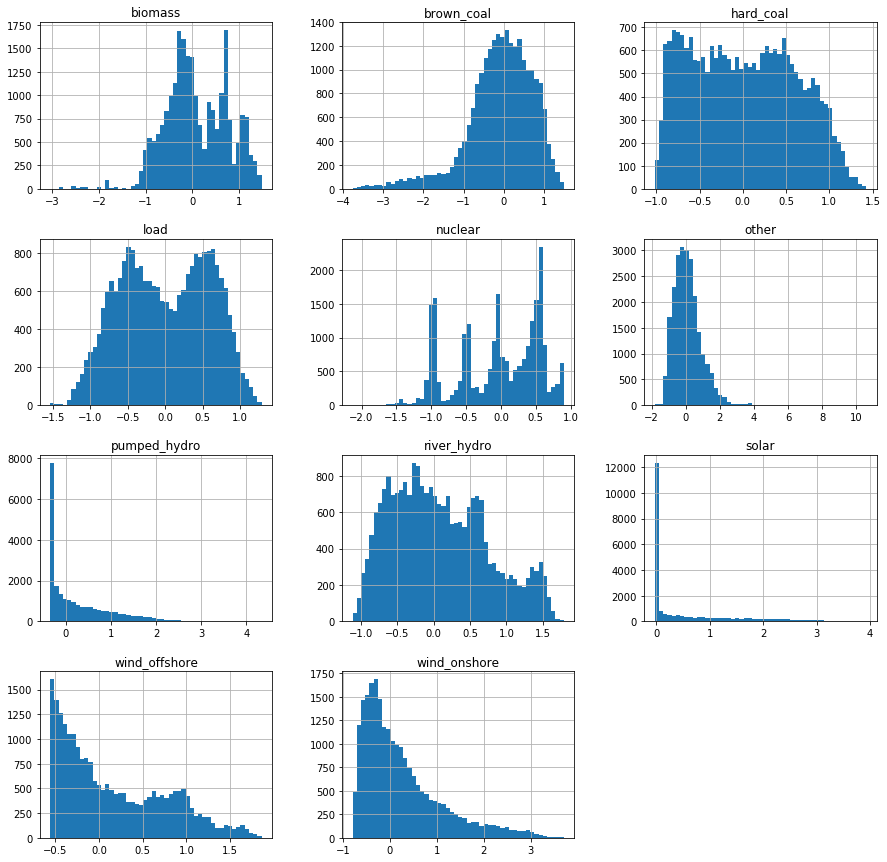

In [65]:
data_scaled.hist(figsize=(15, 15), bins=50);

In [77]:
data_test = data_scaled['2017']
data_train = data_scaled[data_scaled.index.year != 2017]

In [78]:
da_raw = pd.read_csv('./raw_data/EPEX_spot_DA_auction_hour_prices_20070720-20170831.csv',
                     index_col=0, parse_dates=True)
da_raw.head(n=5)

,DA_price
2007-07-20 00:00:00,25.69
2007-07-20 01:00:00,26.45
2007-07-20 02:00:00,24.33
2007-07-20 03:00:00,23.57
2007-07-20 04:00:00,18.96


In [79]:
# keep raw data of the test set for model evaluation
test_raw = da_raw['2017']

In [80]:
da_scaler = joblib.load('./models/DA_price_scaler.pkl')

In [81]:
da_prep = pd.DataFrame(index=da_raw.index)

# calculate quantiles and inter-quantile range of the data
q75 = da_raw['DA_price'].quantile(.75)
q25 = da_raw['DA_price'].quantile(.25)
IQR = q75 - q25

# values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaces by that value
tol = 3
da_prep['DA_price'] = da_raw['DA_price'].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
da_prep['DA_price'] = da_prep['DA_price'].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)

da_prep['DA_price'] = da_scaler.transform(da_prep['DA_price'].reshape(-1, 1))
# include time lags of timeseries data for 1 week = 7 * 24h = 168h
lags = 168
for l in range(1, lags+1):
    da_prep['l_{}'.format(l)] = da_prep['DA_price'].shift(l)
    
da_prep.dropna(inplace=True)

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  del sys.path[0]


In [98]:
# create feature and label dataframes
prelim_features = da_prep.drop('DA_price', axis=1)
prelim_labels = pd.DataFrame(da_prep['DA_price'])

# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['DA_price'].shift(-i)
prelim_labels.drop('DA_price', axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

features_train = features['2015':'2016']
features_test = features['2017-01-01':'2017-08-30']
labels_train = labels['2015':'2016']
labels_test = labels['2017-01-01':'2017-08-30']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168

# convert pandas data frames to numpy ndarrays
features_train = features_train.as_matrix().reshape(samples_train, timesteps, 1)
features_test = features_test.as_matrix().reshape(samples_test, timesteps, 1)
labels_train = labels_train.as_matrix()
labels_test = labels_test.as_matrix()

# check for correct data shape
features_train.shape, labels_train.shape

((731, 168, 1), (731, 24))

In [99]:
timeseries_model = load_model('./models/timeseries_final_model_tuning.hdf5')

In [100]:
features_train_lin = features_train.reshape(features_train.shape[0], features_train.shape[1])
features_test_lin = features_test.reshape(features_test.shape[0], features_test.shape[1])  
bottleneck_features_train = timeseries_model.predict([features_train, features_train_lin])
bottleneck_features_test = timeseries_model.predict([features_test, features_test_lin])

In [101]:
bneck_train_unscaled = da_scaler.inverse_transform(bottleneck_features_train)
bneck_test_unscaled = da_scaler.inverse_transform(bottleneck_features_test)

In [102]:
input_tensors_train = np.concatenate((data_train.as_matrix(), np.expand_dims(bneck_train_unscaled.flatten(), 1)), axis=1)
input_tensors_test = np.concatenate((data_test.as_matrix(), np.expand_dims(bneck_test_unscaled.flatten(), 1)), axis=1)

In [103]:
output_tensors_train = da_scaler.inverse_transform(labels_train).flatten()
output_tensors_test = da_scaler.inverse_transform(labels_test).flatten()

In [104]:
output_tensors_train = output_tensors_train.reshape(output_tensors_train.shape[0], -1)
output_tensors_test = output_tensors_test.reshape(output_tensors_test.shape[0], -1)

In [105]:
# drop NaN values. Done here because of array length sensitivity
input_tensors_train = input_tensors_train[~np.isnan(input_tensors_train).any(axis=1)]
output_tensors_train = output_tensors_train[~np.isnan(input_tensors_train).any(axis=1)]

In [106]:
# drop NaN values. Done here because of array length sensitivity
input_tensors_test = input_tensors_test[~np.isnan(input_tensors_test).any(axis=1)]
output_tensors_test = output_tensors_test[~np.isnan(input_tensors_test).any(axis=1)]

In [117]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, LassoLars
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [118]:
regressor = LinearRegression()

In [119]:
regressor.fit(input_tensors_train[:, [1, 10, -1]], output_tensors_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [120]:
pred = regressor.predict(input_tensors_test[:, [1, 10, -1]])

In [121]:
pred

array([[ 24.93220618],
       [ 22.51200026],
       [ 23.90634332],
       ..., 
       [ 41.8549317 ],
       [ 38.6667277 ],
       [ 33.7195578 ]])

In [122]:
print(mean_absolute_error(output_tensors_test, pred))

5.11503350123


In [123]:
df = pd.DataFrame({'true':output_tensors_test.flatten(), 'pred':pred.flatten()})

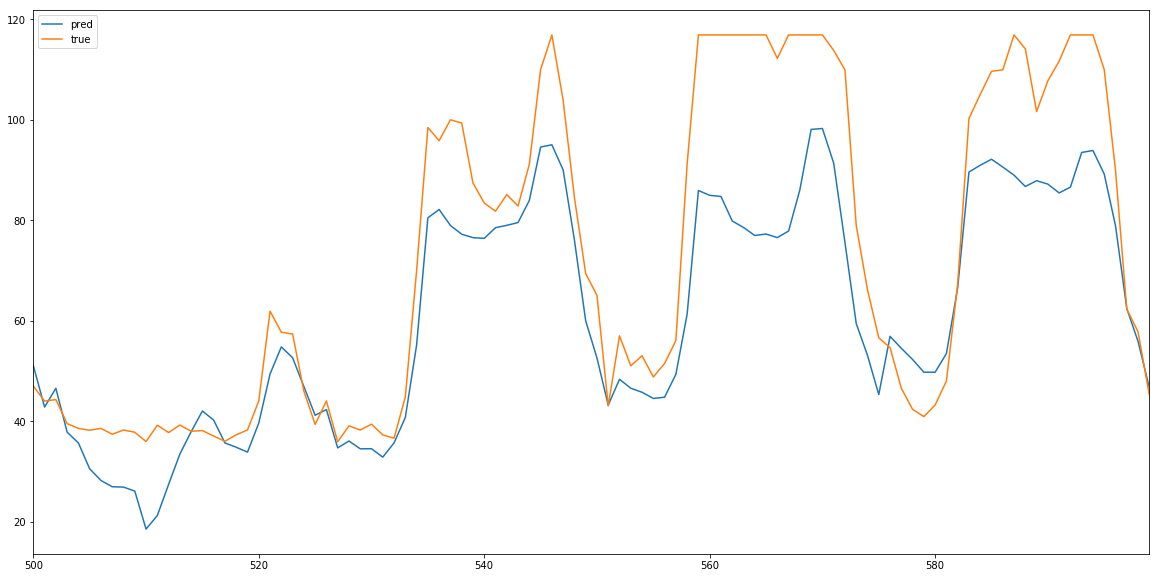

In [125]:
df.iloc[500:600].plot(figsize=(20,10))

In [126]:
from sklearn.svm import SVR

In [127]:
model = SVR(kernel='linear', C=1)

In [ ]:
model.fit(input_tensors_train[:, [2, -1]], output_tensors_train)
pred = model.predict(input_tensors_test[:, [2, -1]])

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [132]:
model.fit(input_tensors_train[:, [3, 10, -1]], output_tensors_train)
pred = model.predict(input_tensors_test[:, [3, 10, -1]])

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [133]:
# pred = scaler_output.inverse_transform(pred.flatten().reshape(-1, 1))
print(mean_absolute_error(output_tensors_test, pred))

5.2844880173


In [281]:
lstm_input_train = scaled_input_tensors_train[:, [2, -1]].reshape(17544//24, 24, 2)
lstm_input_test = scaled_input_tensors_test[:, [2, -1]].reshape(5808//24, 24, 2)

In [282]:
lstm_output_train = scaled_output_tensors_train.reshape(17544//24, 24)

In [283]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

In [284]:
lstm_input_train.shape

(731, 24, 2)

In [285]:
input_layer = Input(shape=(lstm_input_train.shape[1], lstm_input_train.shape[2]))
# x = LSTM(1, return_sequences=True)(input_layer)
x = LSTM(64, activation='linear', return_sequences=True)(input_layer)
x = LSTM(64, activation='linear')(x)
x = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[x])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 24, 2)             0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 24, 64)            17152     
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_15 (Dense)             (None, 24)                1560      
Total params: 51,736
Trainable params: 51,736
Non-trainable params: 0
_________________________________________________________________


In [286]:
model.compile(loss='mse', optimizer='adam')

In [287]:
model.fit(lstm_input_train, lstm_output_train, batch_size=10, epochs=20)

Epoch 1/20
731/731 [==============================] - ETA: 0s - loss: 0.031 - 6s - loss: 0.0316     
Epoch 2/20
731/731 [==============================] - 2s - loss: 0.0031     
Epoch 3/20
731/731 [==============================] - 2s - loss: 0.0029     
Epoch 4/20
731/731 [==============================] - 2s - loss: 0.0028     
Epoch 5/20
731/731 [==============================] - 3s - loss: 0.0027     
Epoch 6/20
731/731 [==============================] - 3s - loss: 0.0031     
Epoch 7/20
731/731 [==============================] - 3s - loss: 0.0027     
Epoch 8/20
731/731 [==============================] - 3s - loss: 0.0026     
Epoch 9/20
731/731 [==============================] - 3s - loss: 0.0026     
Epoch 10/20
731/731 [==============================] - 3s - loss: 0.0027     
Epoch 11/20
731/731 [==============================] - 3s - loss: 0.0025     
Epoch 12/20
731/731 [==============================] - 3s - loss: 0.0026     
Epoch 13/20
731/731 [============================

In [288]:
pred = model.predict(lstm_input_test)
pred = scaler_output.inverse_transform(pred.flatten().reshape(-1, 1))

In [289]:
print(mean_absolute_error(output_tensors_test, pred))

5.94842797225


In [105]:
lin_input_layer = Input(shape=(scaled_input_tensors_train.shape[1],))
# x = Dense(10)(lin_input_layer)
x = Dense(1)(lin_input_layer)

model = Model(inputs=[lin_input_layer], outputs=[x])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [236]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_plus_forecasts.hdf5', save_best_only=True)
hist = model.fit(scaled_input_tensors_train, scaled_output_tensors_train,
                 callbacks=[checkpoint], 
                 verbose=1, batch_size=10, epochs=5)

# best = load_model('./models/timeseries_plus_forecasts.hdf5')
pred = model.predict(scaled_input_tensors_test)
pred = scaler_output.inverse_transform(pred.flatten().reshape(-1, 1))


Epoch 1/5
17544/17544 [==============================] - 2s - loss: 0.0018     
Epoch 2/5
 1200/17544 [=>............................] - ETA: 2s - loss: 0.0019

/home/fritz/opt/anaconda3/envs/datascience/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


17544/17544 [==============================] - 2s - loss: 0.0018     
Epoch 3/5
17544/17544 [==============================] - 1s - loss: 0.0018     
Epoch 4/5
17544/17544 [==============================] - 2s - loss: 0.0018     
Epoch 5/5
17544/17544 [==============================] - 2s - loss: 0.0018     


In [237]:
print(mean_absolute_error(output_tensors_test, pred))

5.09016250743
